# Touchscreen Dataset Analysis

### Package Import and Path Configuration
This section imports all required packages and defines the file paths needed for the analysis.

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from collections import defaultdict
from sklearn.model_selection import train_test_split
from helpers.readFiles import load_tsv, load_csv
from helpers.processDataframes import (na_elimination, 
                                       impute_by_disease, 
                                       get_highly_correlated_columns_from_matrix, 
                                       eliminate_fields_by_fieldID, 
                                       remove_outliers_and_align_datasets, 
                                       rename_columns_with_field_names, 
                                       rename_onehot_columns,
                                       merge_dataframes_on_eid)
from helpers.vizualization import (create_boxplots, 
                                   correlation_matrix_spearman, 
                                   correlation_matrix_crammer, 
                                   create_histograms, 
                                   visualize_correlation_matrix)
from helpers.oneHotEncoding import (onehot_encode_simple_nominal, 
                                    onehot_encode_multiple_nominal)
from helpers.scaleDataFrame import scale_numeric_columns

# Set the path to the directory containing the raw data files
inputpath = "../main/data/UK_BIOBANK_DATA" 
path_graphs = "../main/doutputs/graphs" 
path_results = "../main/doutputs/results" 
path_outputs = "/outputs"

The touchscreen dataset is loaded. This dataset is provided with a tab separator format. For that reason, the following code was used.

In [2]:
#Charge dataframes
#Touchscreen
touchscreen_df = load_tsv("touchscreen_data.tsv", inputpath)

# Display the first few rows of the touchscreen data
touchscreen_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/touchscreen_data.tsv
File loaded: 502180 rows × 1541 columns


,eid,f_670_0_0,f_670_1_0,f_670_2_0,f_670_3_0,f_680_0_0,f_680_1_0,f_680_2_0,f_680_3_0,f_699_0_0,...,f_22037_2_0,f_22037_3_0,f_22038_0_0,f_22038_1_0,f_22038_2_0,f_22038_3_0,f_22039_0_0,f_22039_1_0,f_22039_2_0,f_22039_3_0
0,1000012,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,1.0,NaN,NaN,NaN,2.0,NaN,NaN,NaN,24.0,...,NaN,NaN,4320.0,NaN,NaN,NaN,320.0,NaN,NaN,NaN
2,1000035,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,10.0,...,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN
3,1000044,1.0,1.0,NaN,NaN,2.0,2.0,NaN,NaN,27.0,...,NaN,NaN,0.0,240.0,NaN,NaN,0.0,960.0,NaN,NaN
4,1000053,1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,32.0,...,NaN,NaN,240.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN


The chars dataset is loaded, which contains information relevant to the original dataset. This is done to gain more information, better understand the dataset, and make future associations.

In [3]:
touchscreen_chars_df = load_tsv("touchscreen_chars.tsv", inputpath, skiprows=5)

touchscreen_chars_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/touchscreen_chars.tsv
File loaded: 379 rows × 17 columns


,Field,FieldID,ValueType,Coding,Category,Participants,Items,Stability,Units,ItemType,Strata,Sexed,Instances,Array,Notes,Link,Path
0,Type of accommodation lived in,670,Categorical single,100286.0,100066,501527,597706,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""What type of acco...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=670,Assessment centre > Touchscreen > Sociodemogra...
1,Own or rent accommodation lived in,680,Categorical single,100287.0,100066,500149,596187,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Do you own or ren...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=680,Assessment centre > Touchscreen > Sociodemogra...
2,Length of time at current address,699,Integer,100290.0,100066,501523,597702,Complete,years,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many years ha...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=699,Assessment centre > Touchscreen > Sociodemogra...
3,Number in household,709,Integer,100291.0,100066,500147,596185,Complete,people,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""Including yoursel...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=709,Assessment centre > Touchscreen > Sociodemogra...
4,Number of vehicles in household,728,Categorical single,100293.0,100066,500147,596185,Complete,NaN,Data,Primary,Unisex,4,1,"ACE touchscreen question """"""""How many cars or ...",http://biobank.ndph.ox.ac.uk/ukb/field.cgi?id=728,Assessment centre > Touchscreen > Sociodemogra...


Load the file containing the codes of the categorical questions

In [4]:
#Charge dataframes
#Touchscreen
touchscreen_cbkeys_df = load_tsv("touchscreen_cbkeys.tsv",inputpath)

touchscreen_cbkeys_df.head()

Looking for file at: ../main/data/UK_BIOBANK_DATA/touchscreen_cbkeys.tsv
File loaded: 889 rows × 6 columns


,coding_name,code,meaning,concept,display_order,parent_code
0,7,1,Yes,NaN,1,NaN
1,7,0,No,NaN,2,NaN
2,100286,1,A house or bungalow,NaN,1,NaN
3,100286,2,"A flat, maisonette or apartment",NaN,2,NaN
4,100286,3,Mobile or temporary structure (i.e. caravan),NaN,3,NaN


The tests were conducted in three (3) stages. Across these stages, only instances 0 and 1 were retained, because this stage contains the least amount of missing data.

In [5]:
# Select columns that match the pattern 'f_\d+_0_\d+' and include 'eid'
# _instances_array 
# instances cohort 
# array number of options 

selected_columns = ['eid'] + [
    col for col in touchscreen_df.columns
    if re.match(r'^f_\d+_0_\d+$', col)
]

# Create a new DataFrame with the selected columns
touchscreen_dr_df = touchscreen_df[selected_columns]

touchscreen_dr_df.head()

,eid,f_670_0_0,f_680_0_0,f_699_0_0,f_709_0_0,f_728_0_0,f_738_0_0,f_757_0_0,f_767_0_0,f_777_0_0,...,f_20162_0_0,f_21000_0_0,f_22032_0_0,f_22033_0_0,f_22034_0_0,f_22035_0_0,f_22036_0_0,f_22037_0_0,f_22038_0_0,f_22039_0_0
0,1000012,1.0,1.0,4.0,3.0,3.0,3.0,NaN,NaN,NaN,...,NaN,1001.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1000021,1.0,2.0,24.0,4.0,2.0,3.0,15.0,50.0,6.0,...,0.712500,1001.0,2.0,16.0,370.0,1.0,1.0,3564.0,4320.0,320.0
2,1000035,1.0,3.0,10.0,3.0,1.0,1.0,NaN,NaN,NaN,...,0.462963,1001.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1000044,1.0,2.0,27.0,4.0,3.0,2.0,3.0,35.0,5.0,...,NaN,1001.0,0.0,2.0,15.0,0.0,0.0,99.0,0.0,0.0
4,1000053,1.0,1.0,32.0,2.0,3.0,3.0,NaN,NaN,NaN,...,NaN,1001.0,1.0,10.0,50.0,0.0,1.0,693.0,240.0,0.0


Selection of specific columns 

In [6]:
columns_to_keep = ['eid', 'f_845_0_0', 'f_738_0_0', 'f_22033_0_0', 'f_2178_0_0', 'f_2188_0_0', 'f_2080_0_0', 'f_1200_0_0', 'f_2754_0_0', 'f_1628_0_0']

new_df = touchscreen_dr_df[columns_to_keep]

new_df.head()

,eid,f_845_0_0,f_738_0_0,f_22033_0_0,f_2178_0_0,f_2188_0_0,f_2080_0_0,f_1200_0_0,f_2754_0_0,f_1628_0_0
0,1000012,16.0,3.0,NaN,3.0,0.0,2.0,2.0,NaN,3.0
1,1000021,16.0,3.0,16.0,2.0,0.0,3.0,3.0,NaN,3.0
2,1000035,-1.0,1.0,0.0,4.0,1.0,3.0,3.0,21.0,2.0
3,1000044,16.0,2.0,2.0,4.0,1.0,4.0,3.0,NaN,NaN
4,1000053,NaN,3.0,10.0,2.0,0.0,2.0,2.0,33.0,2.0


In [7]:
# Casos especiales por FieldID
field_replacements = {
    '3710': { -2: 3 },
    '4014': { -2: 3 },  
    '1518': { -2: 4 }
}

# Valores generales
general_replace = { -10: 0.5 }
na_values = [-27, -23, -21, -17, -13, -7, -5, -4, -3, -1, -11]

for col in new_df.columns:
    if col != 'eid':
        new_df[col] = new_df[col].replace(general_replace)
        new_df[col] = new_df[col].replace(na_values, np.nan)

        match = re.match(r'f_(\d+)_\d+_\d+', col)
        if match:
            field_id = match.group(1)
            if field_id in field_replacements:
                new_df[col] = new_df[col].replace(field_replacements[field_id])

new_df.head()

/tmp/ipykernel_21950/2210729155.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].replace(general_replace)
/tmp/ipykernel_21950/2210729155.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df[col] = new_df[col].replace(na_values, np.nan)


,eid,f_845_0_0,f_738_0_0,f_22033_0_0,f_2178_0_0,f_2188_0_0,f_2080_0_0,f_1200_0_0,f_2754_0_0,f_1628_0_0
0,1000012,16.0,3.0,NaN,3.0,0.0,2.0,2.0,NaN,3.0
1,1000021,16.0,3.0,16.0,2.0,0.0,3.0,3.0,NaN,3.0
2,1000035,NaN,1.0,0.0,4.0,1.0,3.0,3.0,21.0,2.0
3,1000044,16.0,2.0,2.0,4.0,1.0,4.0,3.0,NaN,NaN
4,1000053,NaN,3.0,10.0,2.0,0.0,2.0,2.0,33.0,2.0


In [8]:
renamed_df = rename_columns_with_field_names(new_df, touchscreen_chars_df)

renamed_df.head()

,eid,Age completed full time education,Average total household income before tax,Summed days activity,Overall health rating,"Long-standing illness, disability or infirmity",Frequency of tiredness / lethargy in last 2 weeks,Sleeplessness / insomnia,Age at first live birth,Alcohol intake versus 10 years previously
0,1000012,16.0,3.0,NaN,3.0,0.0,2.0,2.0,NaN,3.0
1,1000021,16.0,3.0,16.0,2.0,0.0,3.0,3.0,NaN,3.0
2,1000035,NaN,1.0,0.0,4.0,1.0,3.0,3.0,21.0,2.0
3,1000044,16.0,2.0,2.0,4.0,1.0,4.0,3.0,NaN,NaN
4,1000053,NaN,3.0,10.0,2.0,0.0,2.0,2.0,33.0,2.0


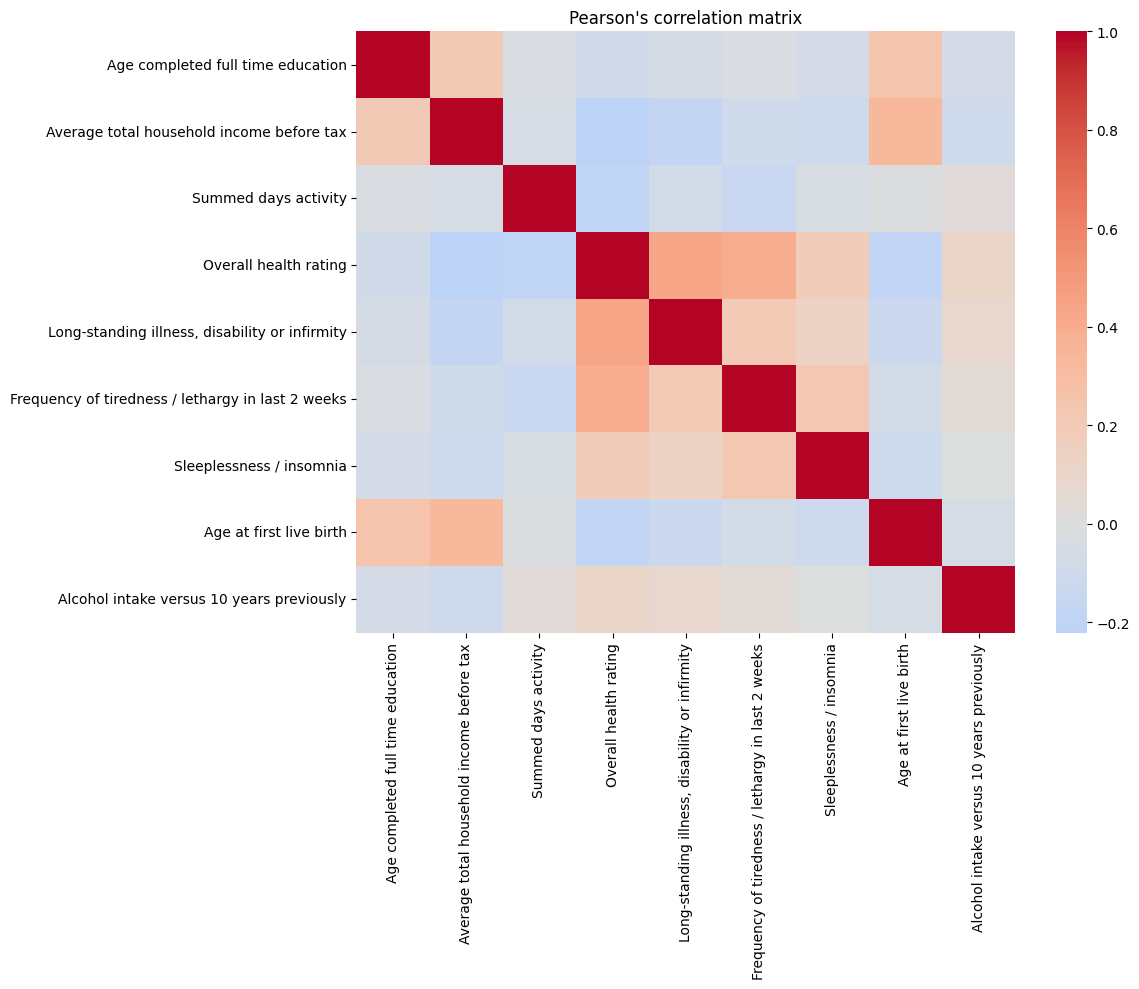

In [9]:
correlation_matrix= renamed_df.drop(columns='eid').corr()

visualize_correlation_matrix(correlation_matrix, 
                             title="Pearson's correlation matrix", 
                             center=0)

In [10]:
get_highly_correlated_columns_from_matrix(correlation_matrix, 
                                          touchscreen_chars_df ,
                                          threshold=0.6)


Pairs found with correlation > 0.6: 0
No pairs were found with correlation above the threshold.


In [11]:
#CategoricalSimple
categorical_collumns = ['eid', 'f_738_0_0', 'f_2178_0_0', 'f_2188_0_0', 'f_2080_0_0', 'f_1200_0_0', 'f_1628_0_0' ]

categorical_simple_df = new_df[categorical_collumns]

categorical_simple_onehot_df = onehot_encode_simple_nominal(categorical_simple_df, touchscreen_chars_df, touchscreen_cbkeys_df)

categorical_simple_onehot_df.head()

,eid,f_738_100294_1,f_738_100294_2,f_738_100294_3,f_738_100294_4,f_738_100294_5,f_2178_100508_1,f_2178_100508_2,f_2178_100508_3,f_2178_100508_4,...,f_2080_100484_1,f_2080_100484_2,f_2080_100484_3,f_2080_100484_4,f_1200_100343_1,f_1200_100343_2,f_1200_100343_3,f_1628_100417_1,f_1628_100417_2,f_1628_100417_3
0,1000012,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,1000021,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
2,1000035,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
3,1000044,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,<NA>,<NA>,<NA>
4,1000053,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0


In [12]:
categorical_renamed = rename_onehot_columns(
    categorical_simple_onehot_df, 
    touchscreen_chars_df, 
    touchscreen_cbkeys_df)

categorical_renamed.head()

,eid,"Average total household income before tax: Less than 18,000","Average total household income before tax: 18,000 to 30,999","Average total household income before tax: 31,000 to 51,999","Average total household income before tax: 52,000 to 100,000","Average total household income before tax: Greater than 100,000",Overall health rating: Excellent,Overall health rating: Good,Overall health rating: Fair,Overall health rating: Poor,...,Frequency of tiredness / lethargy in last 2 weeks: Not at all,Frequency of tiredness / lethargy in last 2 weeks: Several days,Frequency of tiredness / lethargy in last 2 weeks: More than half the days,Frequency of tiredness / lethargy in last 2 weeks: Nearly every day,Sleeplessness / insomnia: Never/rarely,Sleeplessness / insomnia: Sometimes,Sleeplessness / insomnia: Usually,Alcohol intake versus 10 years previously: More nowadays,Alcohol intake versus 10 years previously: About the same,Alcohol intake versus 10 years previously: Less nowadays
0,1000012,0,0,1,0,0,0,0,1,0,...,0,1,0,0,0,1,0,0,0,1
1,1000021,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,0,1,0,0,1
2,1000035,1,0,0,0,0,0,0,0,1,...,0,0,1,0,0,0,1,0,1,0
3,1000044,0,1,0,0,0,0,0,0,1,...,0,0,0,1,0,0,1,<NA>,<NA>,<NA>
4,1000053,0,0,1,0,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0


In [13]:
#numerical values

numeric_colums =['eid', 'f_845_0_0','f_22033_0_0', 'f_2754_0_0']

numeric_colums_df = new_df[numeric_colums]

numeric_colums_df.head()

,eid,f_845_0_0,f_22033_0_0,f_2754_0_0
0,1000012,16.0,NaN,NaN
1,1000021,16.0,16.0,NaN
2,1000035,NaN,0.0,21.0
3,1000044,16.0,2.0,NaN
4,1000053,NaN,10.0,33.0


In [14]:
numeric_renamed_df = rename_columns_with_field_names(numeric_colums_df, touchscreen_chars_df)
numeric_renamed_df.head()

,eid,Age completed full time education,Summed days activity,Age at first live birth
0,1000012,16.0,NaN,NaN
1,1000021,16.0,16.0,NaN
2,1000035,NaN,0.0,21.0
3,1000044,16.0,2.0,NaN
4,1000053,NaN,10.0,33.0


In [15]:
touchscreen_selected_df = pd.merge(
    categorical_renamed, 
    numeric_renamed_df, 
    on='eid', 
    how='inner'
)
touchscreen_selected_df.head()

,eid,"Average total household income before tax: Less than 18,000","Average total household income before tax: 18,000 to 30,999","Average total household income before tax: 31,000 to 51,999","Average total household income before tax: 52,000 to 100,000","Average total household income before tax: Greater than 100,000",Overall health rating: Excellent,Overall health rating: Good,Overall health rating: Fair,Overall health rating: Poor,...,Frequency of tiredness / lethargy in last 2 weeks: Nearly every day,Sleeplessness / insomnia: Never/rarely,Sleeplessness / insomnia: Sometimes,Sleeplessness / insomnia: Usually,Alcohol intake versus 10 years previously: More nowadays,Alcohol intake versus 10 years previously: About the same,Alcohol intake versus 10 years previously: Less nowadays,Age completed full time education,Summed days activity,Age at first live birth
0,1000012,0,0,1,0,0,0,0,1,0,...,0,0,1,0,0,0,1,16.0,NaN,NaN
1,1000021,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,1,16.0,16.0,NaN
2,1000035,1,0,0,0,0,0,0,0,1,...,0,0,0,1,0,1,0,NaN,0.0,21.0
3,1000044,0,1,0,0,0,0,0,0,1,...,1,0,0,1,<NA>,<NA>,<NA>,16.0,2.0,NaN
4,1000053,0,0,1,0,0,0,1,0,0,...,0,0,1,0,0,1,0,NaN,10.0,33.0


In [16]:
touchscreen_selected_df.to_csv(os.path.join(inputpath, "selectedtouchscreen.tsv"), sep="\t", index=False)

Exception ignored in: <function ResourceTracker.__del__ at 0x7f6958688540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f17b5a90540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 82, in __del__
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 91, in _stop
  File "/usr/lib64/python3.13/multiprocessing/resource_tracker.py", line 116, in _stop_locked
ChildProcessError: [Errno 10] No child processes
Exception ignored in: <function ResourceTracker.__del__ at 0x7f683cf90540>
Traceback (most recent call last):
  File "/usr/lib64/python3.13/multip